In [1]:
import json

In [2]:
import os

In [3]:
import matplotlib.pyplot as plt

In [4]:
import PIL.Image as Image

In [5]:
import numpy as np

In [6]:
import torch

In [7]:
import torch.nn as nn

In [8]:
import torch.nn.functional as F

In [9]:
import torchvision.datasets as datasets

In [10]:
from torch.utils.data import DataLoader

In [11]:
import torchvision.transforms as transforms

In [12]:
from models.architectures import Network, VGG

In [13]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


In [14]:
from data.data_prep import Hotdog_NotHotdog

In [15]:
size = 128
batch_size = 64
test_transform = transforms.Compose([transforms.Resize((size, size)),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                    ])
testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

In [16]:
len(testset)

1862

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

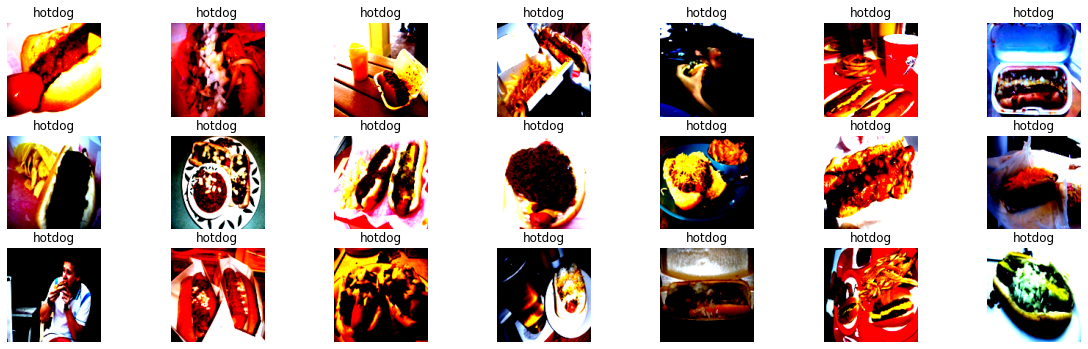

In [17]:
images, labels = next(iter(test_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')

In [18]:
model = Network()

model.load_state_dict(
    torch.load("/zhome/82/e/180411/project_1/DeepLearning-in-ComputerVision/project-1.1/src/models/model_final_adam_aug_128.pt"))
model.eval()

Network(
  (convolutional): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): Dropout(p=0.5, inplace=False)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): Dropout(p=0.5, inplace=False)
    (17): Conv2d(256, 256, ker

In [19]:
test_correct = 0
targets = np.array([])
predictions = np.array([])
data_images = []
model.to(device)
def loss_fun(output, target):
    #return F.nll_loss(torch.log(output), target)
    return F.binary_cross_entropy(output, target)
test_loss = []
test_correct = 0
i = 0
for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    target = target.to(torch.float32)
    with torch.no_grad():
        output = model(data)
    test_loss.append(loss_fun(output, target.reshape(-1,1)).cpu().item())
    predicted = torch.flatten(torch.where(output > 0.5, 1.0, 0.0))
    test_correct += (target==predicted).sum().cpu().item()
    i += 1
    targets = np.concatenate((targets,target.cpu().detach().numpy()))
    predictions = np.concatenate((predictions,predicted.cpu().detach().numpy()))
    #if i != 29:
    data_images.append(data[:].cpu().detach().numpy())

In [20]:
dic = { 0.75 : "hotdog", 0.25: "not-hotdog"}
ticks = [0.25,0.75]
labels = [ticks[i] if t not in dic.keys() else dic[t] for i,t in enumerate(ticks)]

[Text(0.25, 0, 'not-hotdog'), Text(0.75, 0, 'hotdog')]

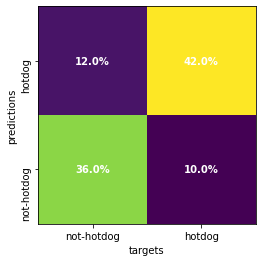

In [21]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
hist, xbins, ybins, im = ax.hist2d(targets, predictions,bins=[2,2])
for i in range(len(ybins)-1):
    for j in range(len(xbins)-1):
        ax.text(xbins[j]+0.25,ybins[i]+0.25, f"{round(hist.T[i,j]/len(predictions),2)*100}%", 
                color="w", ha="center", va="center", fontweight="bold")
ax.set_ylabel('predictions')
ax.set_xlabel('targets')
ax.set_yticks(ticks)
ax.set_yticklabels(labels,rotation=90)
ax.set_xticks(ticks)
ax.set_xticklabels(labels)

In [22]:
with open('/zhome/82/e/180411/project_1/DeepLearning-in-ComputerVision/project-1.1/src/adam_aug_128.json') as json_file:
    adam_aug_128 = json.load(json_file)
with open('/zhome/82/e/180411/project_1/DeepLearning-in-ComputerVision/project-1.1/src/adam_noaug_128.json') as json_file:
    adam_noaug_128 = json.load(json_file)

Text(0, 0.5, 'Loss')

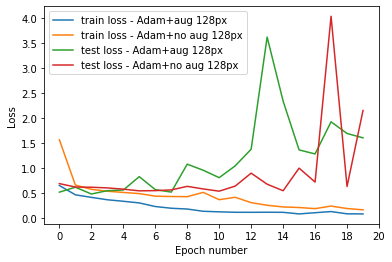

In [23]:
fig, ax = plt.subplots()
ax.plot(np.arange(20),np.array(adam_aug_128["train_loss"]),'-',label="train loss - Adam+aug 128px")
ax.plot(np.arange(20),np.array(adam_noaug_128["train_loss"]),'-',label="train loss - Adam+no aug 128px")
ax.plot(np.arange(20),np.array(adam_aug_128["test_loss"]),'-',label="test loss - Adam+aug 128px")
ax.plot(np.arange(20),np.array(adam_noaug_128["test_loss"]),'-',label="test loss - Adam+no aug 128px")
ax.set_xticks([0,2,4,6,8,10,12,14,16,18,20])
ax.legend()
ax.set_xlabel('Epoch number')
ax.set_ylabel('Loss')

Text(0, 0.5, 'Accuracy')

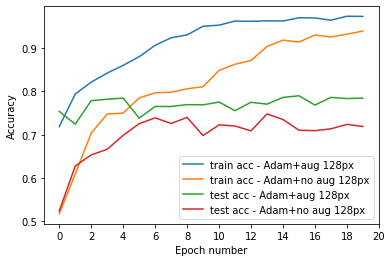

In [24]:
fig, ax = plt.subplots()

ax.plot(np.arange(20),np.array(adam_aug_128["train_acc"]),'-',label="train acc - Adam+aug 128px")
ax.plot(np.arange(20),np.array(adam_noaug_128["train_acc"]),'-',label="train acc - Adam+no aug 128px")
ax.plot(np.arange(20),np.array(adam_aug_128["test_acc"]),'-',label="test acc - Adam+aug 128px")
ax.plot(np.arange(20),np.array(adam_noaug_128["test_acc"]),'-',label="test acc - Adam+no aug 128px")
ax.set_xticks([0,2,4,6,8,10,12,14,16,18,20])
ax.legend()
ax.set_xlabel('Epoch number')
ax.set_ylabel('Accuracy')

In [25]:
def prediction_hist(model):
    test_target = []
    probabilities = []
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        test_target.append(target)
        with torch.no_grad():
            probabilities.append(model(data))
    
    idx = -1
    list_of_true = []
    list_of_false = []
    for proba in probabilities:
        idx += 1
        for i in range(len(proba)):
            if (proba[i][0].item() >= 0.5 and test_target[idx][i] == 0) or (proba[i][0].item() < 0.5 and test_target[idx][i] == 1):
                list_of_false.append(proba[i][0].item())
            else:
                list_of_true.append(proba[i][0].item())

    fig, ax = plt.subplots(1,1, figsize = (8,5))
    #ax.hist([list_of_true, list_of_false], width = 0.04, bins = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], density = True )
    ax.hist([list_of_true, list_of_false], width = 0.04, bins = 10)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_ylabel("Number of Predictions")
    ax.set_xlabel("Probabilities of HotDog")
    ax.legend(["Correct Predictions", "False Predictions"])
    ax.set_xticks(np.linspace(-0.05,0.95,11), ["", "0-10%", "11-20%", "21-30%", "31-40%", "41-50%", "51-60%", "61-70%", "71-80%","81-90%","91-100%"], rotation = 45)
    #ax.set_ylim(0,100)
    plt.show() 
    
    f, (ax, ax2) = plt.subplots(2, 1, sharex=True)
    
    # plot the same data on both axes
    ax.hist([list_of_true, list_of_false], width = 0.04, bins = 10,label=["Correct Predictions", "False Predictions"])
    ax2.hist([list_of_true, list_of_false], width = 0.04, bins = 10,label=["Correct Predictions", "False Predictions"])
    # zoom-in / limit the view to different portions of the data
    ax.set_ylim(550, 720)  # outliers only
    ax2.set_ylim(0, 150)  # most of the data
    
    # hide the spines between ax and ax2
    ax.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax.xaxis.tick_top()
    ax.tick_params(labeltop=False)  # don't put tick labels at the top
    ax2.xaxis.tick_bottom()
    
    d = .015  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
    ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
    ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

    
    ax2.set_ylabel("Number of Predictions")
    ax2.set_xlabel("Probabilities of HotDog")
    ax.legend(["Correct Predictions", "False Predictions"])
    ax2.set_xticks(np.linspace(-0.05,0.95,11), ["", "0-10%", "11-20%", "21-30%", "31-40%", "41-50%", "51-60%", "61-70%", "71-80%","81-90%","91-100%"], rotation = 45)
    #ax.set_ylim(0,100)
    # What's cool about this is that now if we vary the distance between
    # ax and ax2 via f.subplots_adjust(hspace=...) or plt.subplot_tool(),
    # the diagonal lines will move accordingly, and stay right at the tips
    # of the spines they are 'breaking'

    plt.show()

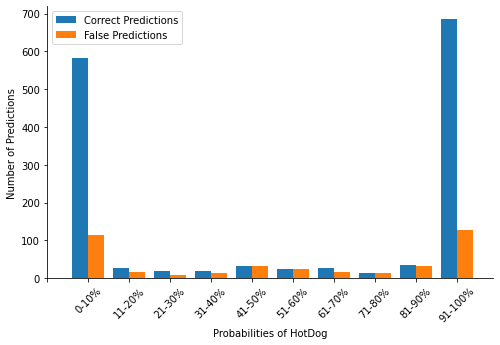

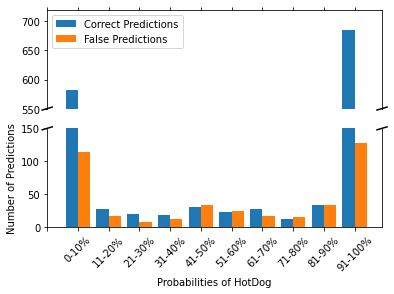

In [26]:
prediction_hist(model)

In [27]:
import torch
import torchvision
import torchvision.transforms as transforms

In [28]:
#load pretrained resnet model
model2 = torchvision.models.resnet50(pretrained=True)
#print(model)
model2.to(device)
#define transforms to preprocess input image into format expected by model
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
#inverse transform to get normalize image back to original form for visualization
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

#transforms to resize image to the size expected by pretrained model,
#convert PIL image to tensor, and
#normalize the image
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    normalize,          
])

In [29]:
import numpy as np
import matplotlib.pyplot as plt

def saliency(img, model):
    #we don't need gradients w.r.t. weights for a trained model
    for param in model.parameters():
        param.requires_grad = False
    
    #set model in eval mode
    model.eval()
    #transoform input PIL image to torch.Tensor and normalize
    input = transform(img)
    input.unsqueeze_(0)

    #we want to calculate gradient of higest score w.r.t. input
    #so set requires_grad to True for input 
    input.requires_grad = True
    #print(input)
    #forward pass to calculate predictions
    preds = model(input)
    #print(preds)
    score, indices = torch.max(preds, 1)
    #backward pass to get gradients of score predicted class w.r.t. input image
    score.backward()
    #get max along channel axis
    slc, _ = torch.max(torch.abs(input.grad[0]), dim=0)
    #print(input.grad[0])
    #normalize to [0..1]
    slc = (slc - slc.min())/(slc.max()-slc.min())
    #apply inverse transform on image
    with torch.no_grad():
        input_img = inv_normalize(input[0])
    #plot image and its saleincy map
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(input_img.cpu().detach().numpy(), (1, 2, 0)))
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1, 2, 2)
    plt.imshow(slc.cpu().detach().numpy(), cmap=plt.cm.hot)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    return slc

In [30]:
images, labels = next(iter(test_loader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


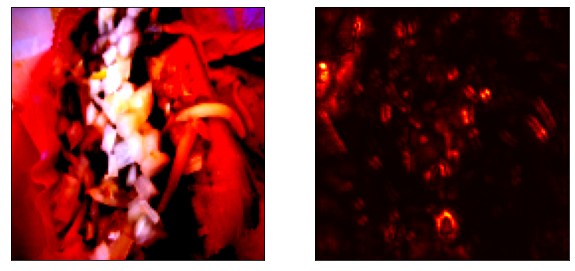

In [31]:
img = images[1].to(device)
slc = saliency(img, model)

In [36]:
test_transform_nonorm = transforms.Compose([transforms.Resize((size, size)),
                                     transforms.ToTensor()
                                    ])
testset_nonorm = Hotdog_NotHotdog(train=False, transform=test_transform_nonorm)
test_loader_nonorm = DataLoader(testset_nonorm, batch_size=batch_size, shuffle=False, num_workers=3)

In [37]:
images_nonorm, labels_nonorm = next(iter(test_loader_nonorm))

In [38]:
len(images_nonorm)

64

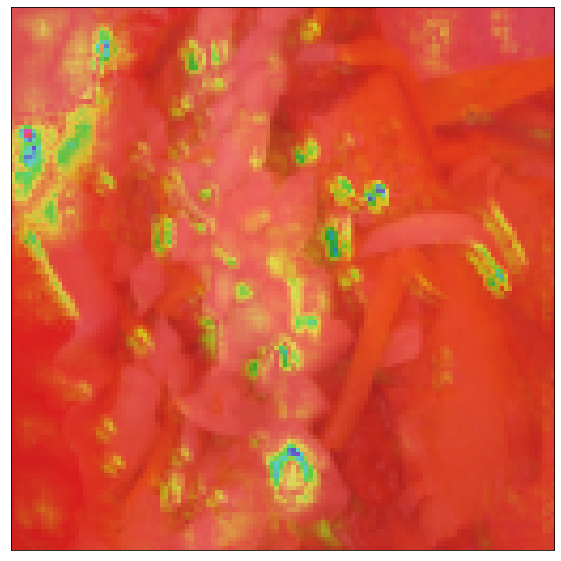

In [39]:
plt.figure(figsize=(10, 10))
#plt.subplot(1, 2, 1)
plt.imshow(np.transpose(images_nonorm[1].cpu().detach().numpy(), (1, 2, 0)),alpha=0.8)
plt.xticks([])
plt.yticks([])
#plt.subplot(1, 2, 2)
plt.imshow(slc.cpu().detach().numpy(), cmap=plt.cm.hsv,alpha=0.5)
plt.xticks([])
plt.yticks([])
plt.show()

In [84]:
hotdog_not_recognized = np.argwhere(np.logical_and(targets==1,predictions==0))

In [85]:
not_hotdog_seen_as_hotdog = np.argwhere(np.logical_and(targets==0,predictions==1))

In [123]:
batch_id_hotdog_not_recognized = np.floor(np.where(np.logical_and(targets==0,predictions==1))[0]/64.)
index_in_batch_hotdog_not_recognized = np.where(np.logical_and(targets==0,predictions==1))[0] - batch_id_hotdog_not_recognized*64

In [124]:
img = list(iter(test_loader))[int(batch_id_hotdog_not_recognized[2])][0][int(index_in_batch_hotdog_not_recognized[2])]

In [125]:
img_nonorm = list(iter(test_loader_nonorm))[int(batch_id_hotdog_not_recognized[2])][0][int(index_in_batch_hotdog_not_recognized[2])]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


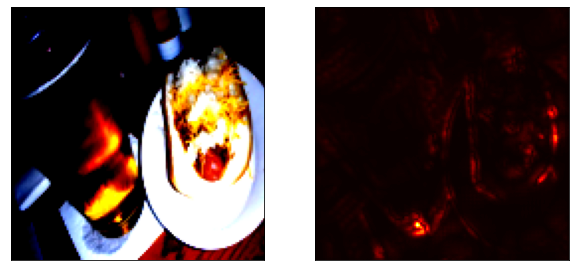

In [126]:
slc = saliency(img.to(device), model)

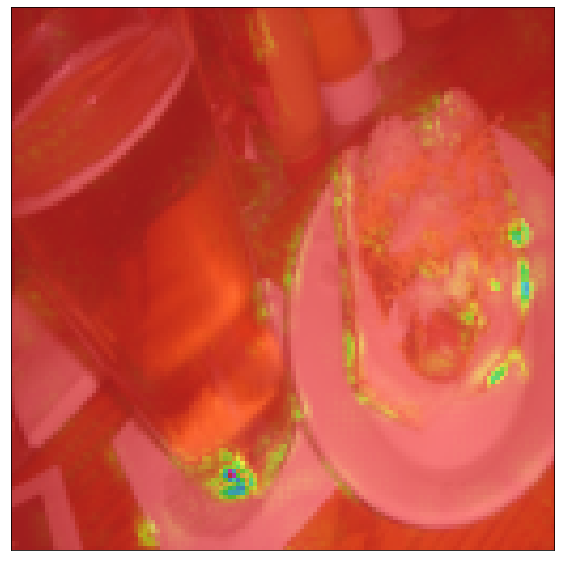

In [127]:
plt.figure(figsize=(10, 10))
#plt.subplot(1, 2, 1)
plt.imshow(np.transpose(img_nonorm.cpu().detach().numpy(), (1, 2, 0)),alpha=0.8)
plt.xticks([])
plt.yticks([])
#plt.subplot(1, 2, 2)
plt.imshow(slc.cpu().detach().numpy(), cmap=plt.cm.hsv,alpha=0.5)
plt.xticks([])
plt.yticks([])
plt.show()

In [128]:
list(iter(test_loader))[int(batch_id_hotdog_not_recognized[2])]

[tensor([[[[ 0.8789,  0.9303,  0.9646,  ..., -0.5596, -0.4911, -0.7137],
           [ 0.9132,  0.9646,  0.9817,  ..., -0.6794, -0.7822, -0.8507],
           [ 0.9303,  0.9646,  0.9988,  ..., -0.5767, -0.7650, -0.8849],
           ...,
           [-0.1999, -0.1657, -0.0972,  ...,  1.7694,  1.6838,  1.6153],
           [ 0.1254,  0.1426,  0.1597,  ...,  1.7523,  1.6667,  1.6324],
           [ 0.3481,  0.3823,  0.4166,  ...,  1.7180,  1.6324,  1.5810]],
 
          [[ 0.6429,  0.7304,  0.7654,  ..., -0.9503, -1.0203, -1.3529],
           [ 0.7129,  0.7654,  0.8004,  ..., -1.2479, -1.3354, -1.5105],
           [ 0.7479,  0.7829,  0.8354,  ..., -1.1954, -1.3880, -1.5105],
           ...,
           [-1.2304, -1.2304, -1.2304,  ...,  1.5182,  1.4482,  1.3957],
           [-0.5301, -0.5301, -0.6001,  ...,  1.4832,  1.4132,  1.3957],
           [-0.0399, -0.0224, -0.0224,  ...,  1.4832,  1.4132,  1.3957]],
 
          [[ 0.7576,  0.8274,  0.8622,  ..., -1.0201, -0.9853, -1.3339],
           [ 

In [ ]:
# OBS for some reason it looks like there is the wrong connections between prediction and target?